In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/015GithubRepos/da_for_sbr')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/015GithubRepos/da_for_sbr')

        

import pickle
import os
import matplotlib.pyplot as plt
from collections import Counter

from preprocessing import *
from simmetric import *

experiment = 1

dataPATH = '/content/drive/MyDrive/015GithubRepos/da_for_sbr/exps'
expPATH = '/content/drive/MyDrive/015GithubRepos/da_for_sbr/exps'


# dataPATH = 'G:/내 드라이브/015GithubRepos/da_for_sbr/exps'
# expPATH = 'G:/내 드라이브/015GithubRepos/da_for_sbr/exps'


if not os.path.exists(f'exps/experiment{experiment}'):
    os.makedirs(f'exps/experiment{experiment}')

In [ ]:
#%% 폴더 만들고 저장

if not os.path.exists(f'exps/experiment{experiment}/yoochoose'):
    os.makedirs(f'exps/experiment{experiment}/yoochoose')
    
if not os.path.exists(f'exps/experiment{experiment}/diginetica'):
    os.makedirs(f'exps/experiment{experiment}/diginetica')
    
if not os.path.exists(f'exps/experiment{experiment}/result_narm_yoochoose'):
    os.makedirs(f'exps/experiment{experiment}/result_narm_yoochoose')
    
if not os.path.exists(f'exps/experiment{experiment}/result_narm_diginetica'):
    os.makedirs(f'exps/experiment{experiment}/result_narm_diginetica')
    
if not os.path.exists(f'exps/experiment{experiment}/result_srgnn_yoochoose'):
    os.makedirs(f'exps/experiment{experiment}/result_srgnn_yoochoose')
    
if not os.path.exists(f'exps/experiment{experiment}/result_srgnn_diginetica'):
    os.makedirs(f'exps/experiment{experiment}/result_srgnn_diginetica')



# 원본데이터 불러오기, 전처리

In [4]:
y_or_d = 'yoochoose'  # yoochoose or diginetica

In [ ]:
#%% 한 번만 실행하면됨

y_or_d = 'diginetica'

if y_or_d == 'yoochoose':
    filename = 'yoochoose-clicks-withHeader.dat'  # 원본 데이터 파일
    tra_sess, tes_sess, sess_clicks = prep_yoochoose(dataPATH, filename)
    fracs = [1/64, 1/128, 1/256, 1/512]
    
else:
    filename = 'train-item-views.csv'  # 원본 데이터 파일
    tra_sess, tes_sess, sess_clicks = prep_diginetica(dataPATH, filename)
    fracs = [1/1, 1/3, 1/6, 1/12]

# 원본데이터 전처리(통계량 확인차)
print(f'원본데이터 통계량')
tra_ids_ori, tra_dates_ori, tra_seqs_ori, item_dict_ori = obtian_tra(sess_clicks, tra_sess)

0it [00:00, ?it/s]

원래 데이터의 training 세션 수 : 186670
-- Starting @ %ss : 2021-12-24 15:25:09.154260+09:00
약 26초


1235380it [00:14, 87088.01it/s]


-- Reading data @ 2021-12-24 15:25:24.046016s
Splitting date 1464102000.0
원본데이터 통계량
train 세션 수 : 186670
train 아이템 수 :  43097


In [ ]:
#%% train 데이터로 저장 (마지막 아이템 떼서 라벨로)
from preprocessing import *
for f in fracs:
    split_frac = int(len(tra_sess) * f)
    tra_sess_frac = tra_sess[-split_frac:]
    
    print(f'----------------------------------------------')
    print(f'frac : 1/{int(1/f)}')
    tra_ids_frac, tra_dates_frac, tra_seqs_frac, item_dict_frac = obtian_tra(sess_clicks, tra_sess_frac)
    tes_ids, tes_dates, tes_seqs = obtian_tes(sess_clicks, tes_sess, item_dict_frac)
    save_tra_seqs_frac(experiment, y_or_d, f, tra_seqs_frac)

    # frac train데이터 저장
    tr_seqs_frac, tr_dates_frac, tr_labs_frac, tr_ids_frac = process_seqs(tra_seqs_frac, tra_dates_frac)
    te_seqs, te_dates, te_labs, te_ids = process_seqs(tes_seqs, tes_dates)
    tra_frac = (tr_seqs_frac, tr_labs_frac)
    tes = (te_seqs, te_labs)
    
    train_name = f'exps/experiment{experiment}/{y_or_d}/{y_or_d[0]}{int(1/f):03}_train.txt'
    print(f'train_name : {train_name}')
    test_name = f'exps/experiment{experiment}/{y_or_d}/{y_or_d[0]}{int(1/f):03}_test.txt'
    print(f'test_name : {test_name}')
    pickle.dump(tra_frac, open(train_name, 'wb'))
    pickle.dump(tes, open(test_name, 'wb'))

----------------------------------------------
frac : 1/1
train 세션 수 : 186670
train 아이템 수 :  43097
test 세션 총 개수 : 15963
test 데이터 아이템 수 :  21131
tra_seqs save dir : exps/experiment1/diginetica/d001_tra_seqs.pkl
train_name : exps/experiment1/diginetica/d001_train.txt
test_name : exps/experiment1/diginetica/d001_test.txt
----------------------------------------------
frac : 1/3
train 세션 수 : 62223
train 아이템 수 :  36427
test 세션 총 개수 : 15644
test 데이터 아이템 수 :  19651
tra_seqs save dir : exps/experiment1/diginetica/d003_tra_seqs.pkl
train_name : exps/experiment1/diginetica/d003_train.txt
test_name : exps/experiment1/diginetica/d003_test.txt
----------------------------------------------
frac : 1/6
train 세션 수 : 31111
train 아이템 수 :  29129
test 세션 총 개수 : 15000
test 데이터 아이템 수 :  17063
tra_seqs save dir : exps/experiment1/diginetica/d006_tra_seqs.pkl
train_name : exps/experiment1/diginetica/d006_train.txt
test_name : exps/experiment1/diginetica/d006_test.txt
------------------------------------------

In [5]:
from preprocessing import *

frac = 1/64

# tra_seqs_frac 불러오기
tra_seqs_frac = load_tra_seqs_frac(experiment, y_or_d, frac)

# 아이템의 출현 횟수 확인하기
allsess = []
for s in tra_seqs_frac:
  allsess += s

allaprcnt = len(allsess)
print(f'모든 세션의 아이템 출현 수 : {allaprcnt}')

# 아이템별 출현 횟수 카운트
allitemcntr = Counter(allsess)

# 아이템의 개수 구하기
nof_items = len(allitemcntr)

print(f'총 아이템 수 : {nof_items}')

loading file : exps/experiment1/yoochoose/y064_tra_seqs.pkl
124472
모든 세션의 아이템 출현 수 : 519275
총 아이템 수 : 17597


In [ ]:
from simmetric import *

co_mat_win = get_co_matrix_win(tra_seqs_frac, 5, True, True)
save_mat_as_csr(co_mat_win, 'coo_mat', experiment, y_or_d, frac)

pmi_mat = ppmi(co_mat_win, True)
save_mat_as_csr(pmi_mat, 'pmi_mat', experiment, y_or_d, frac)

jac_mat = get_jaccard_mat(tra_seqs_frac, 5, diag_freq = True, remove_dup = True)
save_mat_as_csr(jac_mat, 'jac_mat', experiment, y_or_d, frac)
,v
tan_mat = get_tanimoto(tra_seqs_frac, window_size=5, diag_freq=True, remove_dup=True)
save_mat_as_csr(tan_mat, 'tan_mat', experiment, y_or_d, frac)

cos_mat_win = get_cosine(co_mat_win)
save_mat_as_csr(cos_mat_win, 'cos_mat', experiment, y_or_d, frac)

w2v_mat = get_w2v_model(tra_seqs_frac, nof_items)
save_mat_as_csr(w2v_mat, 'w2v_mat', experiment, y_or_d, frac)

저장파일 : exps/experiment1/yoochoose/y064_csr_coo_mat.pkl


/content/drive/MyDrive/015GithubRepos/da_for_sbr/simmetric.py:104: RuntimeWarning: invalid value encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)  # np.log2(0)이 음의 무한대가 되는 것을 막기위해 eps 사용함


0.0 % 완료
17.047391749062392 % 완료
34.094783498124784 % 완료
51.14217524718718 % 완료
68.18956699624957 % 완료
85.23695874531197 % 완료
저장파일 : exps/experiment1/yoochoose/y064_csr_pmi_mat.pkl
0.0 % 완료
5.682463916354131 % 완료
11.364927832708261 % 완료
17.047391749062392 % 완료
22.729855665416522 % 완료
28.412319581770657 % 완료
34.094783498124784 % 완료
39.777247414478914 % 완료
45.459711330833045 % 완료
51.14217524718718 % 완료
56.82463916354131 % 완료
62.507103079895444 % 완료
68.18956699624957 % 완료
73.8720309126037 % 완료
79.55449482895783 % 완료
85.23695874531197 % 완료
90.91942266166609 % 완료
96.60188657802023 % 완료
저장파일 : exps/experiment1/yoochoose/y064_csr_jac_mat.pkl
10.00% 완료
20.00% 완료
30.00% 완료
40.00% 완료
50.00% 완료
60.00% 완료
70.00% 완료
80.00% 완료
90.00% 완료
100.00% 완료
저장파일 : exps/experiment1/yoochoose/y064_csr_tan_mat.pkl
10.00% 완료
20.00% 완료
30.00% 완료
40.00% 완료
50.00% 완료
60.00% 완료
70.00% 완료
80.00% 완료
90.00% 완료
저장파일 : exps/experiment1/yoochoose/y064_csr_cos_mat.pkl


In [ ]:
w2v_mat = get_w2v_model(tra_seqs_frac, nof_items)
save_mat_as_csr(w2v_mat, 'w2v_mat', experiment, y_or_d, frac)

저장파일 : exps/experiment1/yoochoose/y064_csr_w2v_mat.pkl


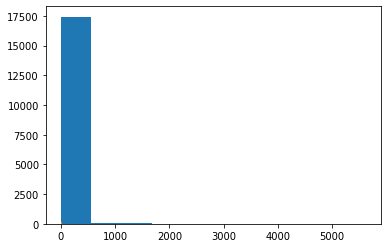

In [35]:
#%% falog2만들기, hs딕셔너리(msd, most hightest similarity dictionary) 불러오기

import math
falog2 = {k:math.log2(v+1) for k, v in allitemcntr.items()}
plt.hist(allitemcntr.values())
plt.hist(falog2_d.values())

from simmetric import *
msd = load_msd('coo', experiment, y_or_d, frac)


# x = [allitemcntr[i] for i in range(1, nof_items+1)]
# y = [msd[i][1] for i in range(1, nof_items+1)]
# plt.scatter(x, y, alpha=0.5)


# M = max([_ for _ in falog2_d.values()])
# x = [falog2_d[i] for i in range(1, nof_items+1)]
# y = [msd[i][1] for i in range(1, nof_items+1)]
# plt.scatter(x, y, alpha=0.5)


# min(falog2_d.values())


# math.log2(2)

In [119]:
nof_sessions = len(tra_seqs_frac)
ar = 0.25  # augmentation rate

nof_aug = int(nof_sessions * 0.25)  # number of augmentation
print(f'number of sessions : {nof_sessions}')
print(f'augmentation rate : {ar}')
print(f'number of augmentation : {nof_aug}')

number of sessions : 124472
augmentation rate : 0.25
number of augmentation : 31118


In [ ]:
int(len(tra_seqs_frac) * 0.25)

31118

In [19]:
#%% hyperparameter setting

alpha = 500
mu1 = 0
sigma1 = 3

beta = 500
mu2 = 1
sigma2 = 0.4

theta = [alpha, mu1, sigma1, beta, mu2, sigma2]

In [39]:
def cal_score(logfa: float , hsvalue: float, theta) -> float:

  alpha, mu1, sigma1, beta, mu2, sigma2 = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]

  alphaterm = alpha * gaussian(mu1, sigma1, logfa)
  betaterm = beta * gaussian(mu2, sigma2, hsvalue)

  score = alphaterm + betaterm

  return score

In [40]:
score = {i : cal_score(falog2[i], msd[i][1], theta) for i in range(1, nof_items+1)}

In [83]:
#%% 세션의 평균 살짝 보기

for _ in range(10000, 10100):
    s = tra_seqs_frac[_]
    
    scoresum = 0
    scorelist = []

    slen = len(s)
    scorelist = [score[item] for idx, item in enumerate(s)]
    p = np.array(scorelist) / np.sum(scorelist)
    print(f'{_}, session : {s} \nscore list : {np.asarray(scorelist, dtype=int)}')
    print(f'mean : {np.mean(scorelist):.0f}')
    print(f'median : {np.median(scorelist):.0f}')
    print()

10000, session : [334, 3649, 335, 334, 333, 336, 333, 338, 5191, 333, 336, 2185, 4017, 141, 3073, 2656, 4340, 5395, 4761, 951] 
score list : [53 54 39 53 63 48 63 94 65 63 48 54 61 59 62 56 51 81 54 57]
mean : 59
median : 57

10001, session : [5396, 5397] 
score list : [159 291]
mean : 225
median : 225

10002, session : [85, 193] 
score list : [33 33]
mean : 33
median : 33

10003, session : [3903, 525, 527, 527, 3903, 4697] 
score list : [199  62  43  43 199  85]
mean : 106
median : 74

10004, session : [9, 94, 17, 17] 
score list : [37 45 29 29]
mean : 36
median : 33

10005, session : [1769, 1769, 1769] 
score list : [54 54 54]
mean : 55
median : 55

10006, session : [880, 180] 
score list : [33 33]
mean : 34
median : 34

10007, session : [126, 232, 1433, 126, 1497, 5398, 5399, 551, 5400, 288, 1993, 1613, 84, 5401] 
score list : [34 50 51 34 33 55 56 33 61 64 31 34 34 51]
mean : 45
median : 43

10008, session : [18, 18, 18, 18] 
score list : [48 48 48 48]
mean : 48
median : 48

10009,

In [90]:
sess_score_mean = dict()
for sid, s in enumerate(tra_seqs_frac):
  scorelist = [score[item] for idx, item in enumerate(s)]
  sess_score_mean[sid] = (np.mean(scorelist), len(s))  # sess_score_mean[session id] = (session's score mean, session length)

In [131]:
tra_seqs_frac[3454]

[2875, 2876]

In [132]:
tra_seqs_frac[12325]

[6295, 6296]

In [146]:
aug_target = sorted(sess_score_mean.items(), key=lambda x: (x[1][0], -x[1][1]), reverse=True)

In [147]:
aug_target

[(156, (556.5071653814214, 2)),
 (223, (556.5071653814214, 2)),
 (1219, (556.5071653814214, 2)),
 (1303, (556.5071653814214, 2)),
 (2170, (556.5071653814214, 2)),
 (2501, (556.5071653814214, 2)),
 (2731, (556.5071653814214, 2)),
 (2846, (556.5071653814214, 2)),
 (3113, (556.5071653814214, 2)),
 (3221, (556.5071653814214, 2)),
 (3306, (556.5071653814214, 2)),
 (3733, (556.5071653814214, 2)),
 (3745, (556.5071653814214, 2)),
 (3766, (556.5071653814214, 2)),
 (3803, (556.5071653814214, 2)),
 (3892, (556.5071653814214, 2)),
 (3971, (556.5071653814214, 2)),
 (4277, (556.5071653814214, 2)),
 (4789, (556.5071653814214, 2)),
 (4968, (556.5071653814214, 2)),
 (5203, (556.5071653814214, 2)),
 (5624, (556.5071653814214, 2)),
 (5934, (556.5071653814214, 2)),
 (6014, (556.5071653814214, 2)),
 (6020, (556.5071653814214, 2)),
 (7143, (556.5071653814214, 2)),
 (7285, (556.5071653814214, 2)),
 (8399, (556.5071653814214, 2)),
 (8595, (556.5071653814214, 2)),
 (10703, (556.5071653814214, 2)),
 (10828, (5

In [150]:
aug_target = [_[0] for _ in aug_target]
aug_target[:10]

[156, 223, 1219, 1303, 2170, 2501, 2731, 2846, 3113, 3221]

### 증강 대상 세션 정렬했다(이제 증강 안되는 세션은 건너뛰기)

In [135]:
aug_target_ids[0]

156

In [136]:
tra_seqs_frac[156]

[319, 319]

In [137]:
score[319]

556.5071653814214

In [139]:
allitemcntr[319]

2

In [140]:
msd[319]

(319, 1.0)

In [164]:
np.random.choice(range(3), 1)

array([1])

In [169]:
np.random.choice(range(len(sess)), math.floor(len(sess) * cr), p=p)

array([0])

In [176]:
np.random.choice(range(10), 4, replace=False)

array([0, 7, 6, 0])

In [204]:
cr = 0.5  # choice rate

cnt = 0  # 증강 성공할때마다 하나씩 카운트
aug_sess = []  # 증강 완료된 세션을 모음
for rank, sid in enumerate(aug_target):

  s = tra_seqs_frac[sid].copy()  # 안변하고 참고하는거
  sess = tra_seqs_frac[sid].copy()  # 실제로 변하는거
  slen = len(sess)

  scorelist = np.array([score[item] for item in sess])

  np.random.choice(range(len(sess)), math.floor(len(sess) * cr))

  p = np.array(scorelist) / np.sum(scorelist)

  augidxs = np.random.choice(range(len(sess)), math.floor(len(sess) * cr), replace=False, p=p)

  nof_sub = np.random.choice(slen + 1, 1)[0]  # 대체할 개수
  sub_it_idxs = augidxs[:nof_sub]
  isrt_it_idxs = augidxs[nof_sub:]


  # sforsub에 대체
  for sitidx in sub_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기 자신과만 유사한 아이템만 아니면 대체
    mostsimitem_s = msd[sess[sitidx]][0]
    if sess[sitidx] != mostsimitem_s:
      sess[sitidx] = mostsimitem_s  # 대체
  
  # 삽입할 아이템 구하기
  isrt_items = []  # 삽입할 아이템을 모음
  isrt_it_idxs_over = []  # 삽입할 인덱스를 모음
  for iitidx in isrt_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기자신과만 유사한 아이템 아니면 삽입
    mostsimitem_i = msd[sess[iitidx]][0]
    if sess[iitidx] != mostsimitem_i:
      isrt_items.append(mostsimitem_i)  # 삽입할 아이템
      isrt_it_idxs_over.append(iitidx)  # 삽입할 인덱스

  sess = np.insert(np.asarray(sess), isrt_it_idxs_over, isrt_items)  # 삽입
  sess = list(sess)

  if s != sess:
    cnt += 1
    print(f'************성공**************')
    aug_sess.append(sess)

  if cnt == nof_aug:
    break
  
  print(f'순위 : {rank}')
  print(f'원래 세션   : {s}')
  print(f'증강된 세션 : {sess}')
  print(f'p : {p}')
  print(f'score mean: {np.mean(scorelist)}')
  print()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
p : [0.20282635 0.26572455 0.26572455 0.26572455]
score mean: 54.92115089745274

************성공**************
순위 : 31257
원래 세션   : [504, 417, 1686, 1261, 168, 712, 2242]
증강된 세션 : [1539, 417, 1686, 42, 168, 203, 2242]
p : [0.10104093 0.14143219 0.10980401 0.12456446 0.08731654 0.12415563
 0.31168623]
score mean: 54.92114157559483

************성공**************
순위 : 31258
원래 세션   : [2787, 27]
증강된 세션 : [1233, 27]
p : [0.54299285 0.45700715]
score mean: 54.920523911692094

************성공**************
순위 : 31259
원래 세션   : [9027, 8710, 525]
증강된 세션 : [109, 8710, 525]
p : [0.40943379 0.21266837 0.37789784]
score mean: 54.919918561415805

************성공**************
순위 : 31260
원래 세션   : [176, 8312]
증강된 세션 : [176, 3263, 8312]
p : [0.25292444 0.74707556]
score mean: 54.91969401500401

************성공**************
순위 : 31261
원래 세션   : [1354, 1431, 5401, 3953, 1432, 1458, 3110, 3482, 5295, 3980, 4187, 2687, 4165, 8741]
증강된 세션 : [1354, 1431, 4682, 3953, 1432, 143

In [209]:
len(aug_sess)

31118

In [211]:
def crop_seqs(iseqs):
    out_seqs = []
    labs = []
    for seq in iseqs:
        for i in range(1, len(seq)):
            tar = seq[-i]  # tar : 맨 뒤 아이템 하나씩 잘라 라벨로
            labs += [tar]
            out_seqs += [seq[:-i]]
    return out_seqs, labs

In [213]:
aug_tra, aug_tra_l = crop_seqs(tra_seqs_frac + aug_sess)
aug_tra_final = (aug_tra, aug_tra_l)
filename = f'testhaha.txt'


In [216]:
filename_save = f'experiment{experiment}/{y_or_d}/'
filename_save

'experiment1/yoochoose/'

In [ ]:
print(f"""{cnt_over:>7}/{cnt_aug_item:>7} = {cnt_over / cnt_aug_item:>7.4f}, {len(tra_seqs_frac):6} + {len(augresult):6}, {y_or_d[0]}{int(1/frac):03}_{simmetabbr}_{apr_thd:04}_{metric_thd:05}_{"".join(sorted(list(set([by1, by2, by3, by4]))))}.txt""")
filename_save = f'experiment{experiment}/{y_or_d}/{y_or_d[0]}{int(1/frac):03}_{simmetabbr}_{apr_thd:04}_{metric_thd:05}_{"".join(sorted(list(set([by1, by2, by3, by4]))))}.txt'

pickle.dump(aug_tra_final, open(filename_save, 'wb'))

In [210]:
aug_sess

[[14849, 14848, 14849, 14848, 14848, 14849],
 [15025, 15025, 15024, 15025, 15025, 15024],
 [11655, 11655, 11655, 11656, 11655, 11655, 11656],
 [13870,
  13871,
  13871,
  13870,
  13871,
  13871,
  13870,
  13870,
  13871,
  13871,
  13871,
  13870,
  13871,
  13870,
  13870,
  13870],
 [13835, 13835, 13834, 13834],
 [15827, 15827, 15828, 15828],
 [16775, 16775, 16775, 16775],
 [14614, 14614, 14613, 14614],
 [5727, 5728, 5727, 5727, 5728, 5728, 5728],
 [15557, 15557, 14969, 15557],
 [17572,
  17572,
  17573,
  17573,
  17572,
  17572,
  17573,
  17572,
  17573,
  17573,
  17572,
  15870],
 [10122, 10123, 10123],
 [10762, 10761, 10762],
 [12196, 12195, 12196, 12195],
 [14283, 14284, 14284],
 [14562, 14561, 14562],
 [14894, 14895, 14895, 14894],
 [15050, 15050, 15049],
 [16258, 16258, 16258],
 [16387, 16387, 16388, 16387],
 [16546, 16546, 16546],
 [16743, 16744, 16744],
 [15230, 15230, 15655, 15655, 15230],
 [16341, 16116, 16341, 16116, 16116],
 [11210, 9273, 9273],
 [5017, 5017, 5017, 5

In [194]:
s

[10440, 10440]

In [193]:
sess

array([10440, 10440])